In [ ]:
from pathlib import Path
import sys
import os, random
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from typing import Optional
import torch


from rps_classification.config import PATHS, Settings
from rps_classification.data_utils import build_transforms


In [ ]:
# paths
ROOT = Path.cwd().parent # il notebook è in ./notebooks/, la root è il parent
sys.path.insert(0, str(ROOT))
PATHS.DATA_RAW, PATHS.DATA_PROC
data_dir = PATHS.DATA_RAW
data_dir_proc = PATHS.DATA_PROC
FIGURES_DIR = Path.cwd() / "figures"

(WindowsPath('C:/Users/dgmar/Isa/rps-image-classification/data/data_rps/rps-cv-images'),
 WindowsPath('C:/Users/dgmar/Isa/rps-image-classification/data/processed'))

In [ ]:
#image formats
IMG_EXTS = {".png", ".jpg", ".jpeg"}

### Raw data

Classes found: ['paper', 'rock', 'scissors']

paper: 712 images
rock: 726 images
scissors: 750 images

Total images: 2188


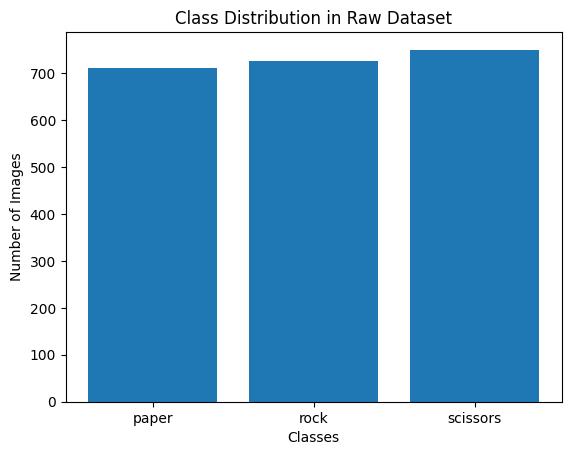

In [33]:
# List classes
classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
print(f"Classes found: {classes}\n")

counts = []
for cls in classes:
    count = len(os.listdir(os.path.join(data_dir, cls)))
    counts.append(count)
    print(f"{cls}: {count} images")

# Count total images
total = sum(counts)
print(f"\nTotal images: {total}")

# ---- Plot class distribution ----
plt.figure()
plt.bar(classes, counts)
plt.title("Class Distribution in Raw Dataset")
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.savefig(FIGURES_DIR / f"class_distribution_raw", dpi=150)
plt.show()

In [34]:
# Check image dimensions
sample_path = os.path.join(data_dir, classes[0], os.listdir(os.path.join(data_dir, classes[0]))[0])
img = Image.open(sample_path)
print(f"\nSample image size: {img.size} (width, height)")
print(f"Mode (color channels): {img.mode}")


Sample image size: (300, 200) (width, height)
Mode (color channels): RGB


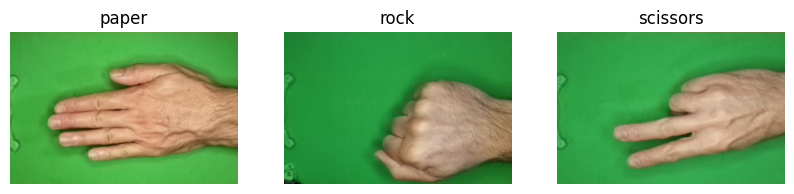

In [35]:
# Visualize examples
fig, axs = plt.subplots(1, 3, figsize=(10, 4))
for i, cls in enumerate(classes):
    img_path = os.path.join(data_dir, cls, os.listdir(os.path.join(data_dir, cls))[0])
    axs[i].imshow(Image.open(img_path))
    axs[i].set_title(cls)
    axs[i].axis("off")

plt.savefig(FIGURES_DIR / f"raw_imgs_viz", dpi=150)

plt.show()

### Data split: train, val, test

In [36]:
train_dir = data_dir_proc / "train"
val_dir   = data_dir_proc / "val"
test_dir  = data_dir_proc / "test"

In [ ]:
def _count_in_dir(d: Path):
    if not d.exists():
        return 0
    return sum(1 for p in d.glob("*") if p.suffix.lower() in IMG_EXTS)

def show_split_stats(train_dir: Path, val_dir: Path, test_dir: Path):
    classes = sorted({p.name for p in train_dir.iterdir() if p.is_dir()}
                     | {p.name for p in val_dir.iterdir() if p.is_dir()}
                     | {p.name for p in test_dir.iterdir() if p.is_dir()})

    print(f"Classes found: {classes}\n")
    header = f"{'class':<15}{'train':>8}{'val':>8}{'test':>8}{'tot':>8}   {'%train':>7}{'%val':>7}{'%test':>7}"
    print(header)
    print("-"*len(header))

    totals = {"train":0, "val":0, "test":0, "all":0}
    split_counts = {} 

    for cls in classes:
        t = _count_in_dir(train_dir/cls)
        v = _count_in_dir(val_dir/cls)
        te = _count_in_dir(test_dir/cls)
        tot = t+v+te
        totals["train"] += t
        totals["val"]   += v
        totals["test"]  += te
        totals["all"]   += tot

        p_train = (t/tot*100) if tot else 0.0
        p_val   = (v/tot*100) if tot else 0.0
        p_test  = (te/tot*100) if tot else 0.0

        print(f"{cls:<15}{t:>8}{v:>8}{te:>8}{tot:>8}   {p_train:6.1f}%{p_val:6.1f}%{p_test:6.1f}%")

        split_counts[cls] = {"train": t, "val": v, "test": te, "total": tot}

    print("-"*len(header))
    P = lambda n: (n/totals["all"]*100) if totals["all"] else 0.0
    print(f"{'TOTAL':<15}{totals['train']:>8}{totals['val']:>8}{totals['test']:>8}{totals['all']:>8}   "
          f"{P(totals['train']):6.1f}%{P(totals['val']):6.1f}%{P(totals['test']):6.1f}%")

    return split_counts  

In [38]:
split_distribution = show_split_stats(train_dir, val_dir, test_dir)

Classes found: ['paper', 'rock', 'scissors']

class             train     val    test     tot    %train   %val  %test
-----------------------------------------------------------------------
paper               498     107     107     712     69.9%  15.0%  15.0%
rock                508     109     109     726     70.0%  15.0%  15.0%
scissors            525     112     113     750     70.0%  14.9%  15.1%
-----------------------------------------------------------------------
TOTAL              1531     328     329    2188     70.0%  15.0%  15.0%


In [39]:
split_distribution

{'paper': {'train': 498, 'val': 107, 'test': 107, 'total': 712},
 'rock': {'train': 508, 'val': 109, 'test': 109, 'total': 726},
 'scissors': {'train': 525, 'val': 112, 'test': 113, 'total': 750}}

In [40]:
def _ensure_dir(d: Path) -> Path:
    d.mkdir(parents=True, exist_ok=True)
    return d

def _to_arrays(stats: dict):
    classes = sorted(stats.keys())
    splits = ["train", "val", "test"]
    train = [stats[c]["train"] for c in classes]
    val   = [stats[c]["val"]   for c in classes]
    test  = [stats[c]["test"]  for c in classes]
    return classes, splits, train, val, test

def plot_by_class(stats: dict, save_dir: Path = None):
    classes, _, train, val, test = _to_arrays(stats)

    # 1 - classi X, split Y
    x = np.arange(len(classes))
    width = 0.25
    plt.figure()
    plt.bar(x - width, train, width, label="train")
    plt.bar(x,         val,   width, label="val")
    plt.bar(x + width, test,  width, label="test")
    plt.xticks(x, classes)
    plt.title("Class distribution by split")
    plt.xlabel("Classes")
    plt.ylabel("Number of images")
    plt.legend()
    plt.tight_layout()
    if save_dir:
        _ensure_dir(save_dir)
        plt.savefig(save_dir / "class_distribution_1.png", dpi=150)
    plt.show()

    # 2 - classi X, split Y
    plt.figure()
    plt.bar(classes, train, label="train")
    bottom = np.array(train)
    plt.bar(classes, val,   bottom=bottom, label="val")
    bottom = bottom + np.array(val)
    plt.bar(classes, test,  bottom=bottom, label="test")
    plt.title("Class distribution by split")
    plt.xlabel("Classes")
    plt.ylabel("Number of images")
    plt.legend()
    plt.tight_layout()
    if save_dir:
        plt.savefig(save_dir / "class_distribution_2.png", dpi=150)
    plt.show()

# 3 - classi Y, split X
def plot_by_split(stats: dict, save_dir: Path = None, prefix: str = "split_distribution"):
    classes, splits, *_ = _to_arrays(stats)
    plt.figure()
    bottom = np.zeros(len(splits))
    for cls in classes:  
        values = [stats[cls][s] for s in splits]
        plt.bar(splits, values, bottom=bottom, label=cls)
        bottom += np.array(values)

    plt.title("Class distribution by split")
    plt.xlabel("Split")
    plt.ylabel("Number of images")
    plt.legend(title="Classes")
    plt.tight_layout()
    if save_dir:
        _ensure_dir(save_dir)
        plt.savefig(save_dir / "class_distribution_3.png", dpi=150)
    plt.show()



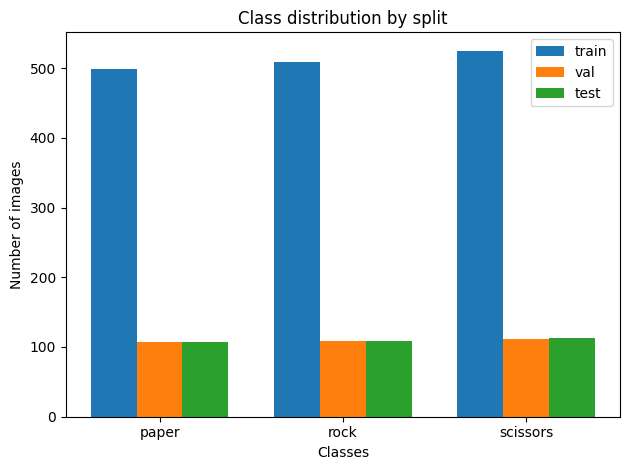

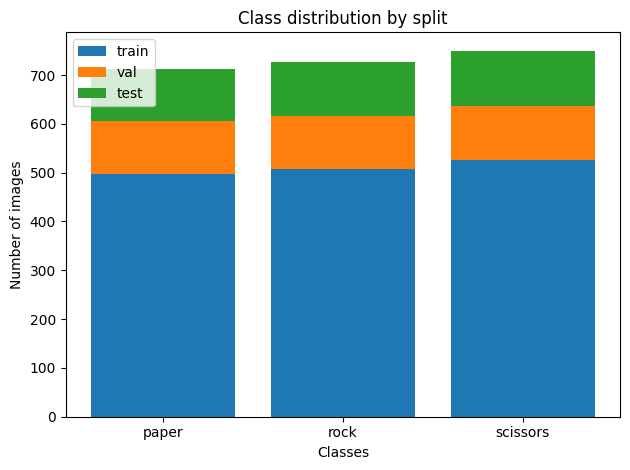

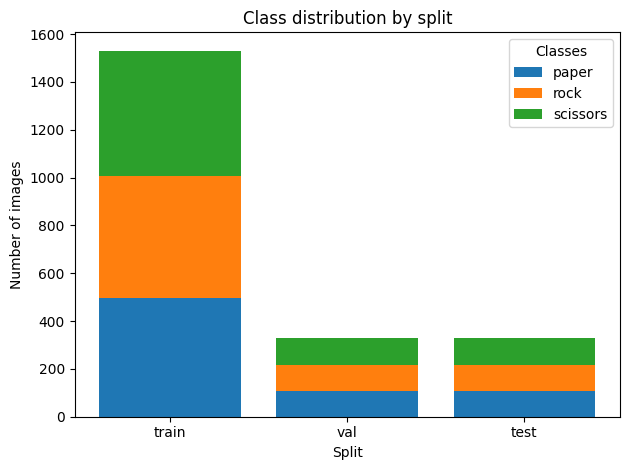

In [41]:
plot_by_class(split_distribution, save_dir=FIGURES_DIR)
plot_by_split(split_distribution, save_dir=FIGURES_DIR)

### Data preprocessing
##### Image resizing, normalization and data augmentation

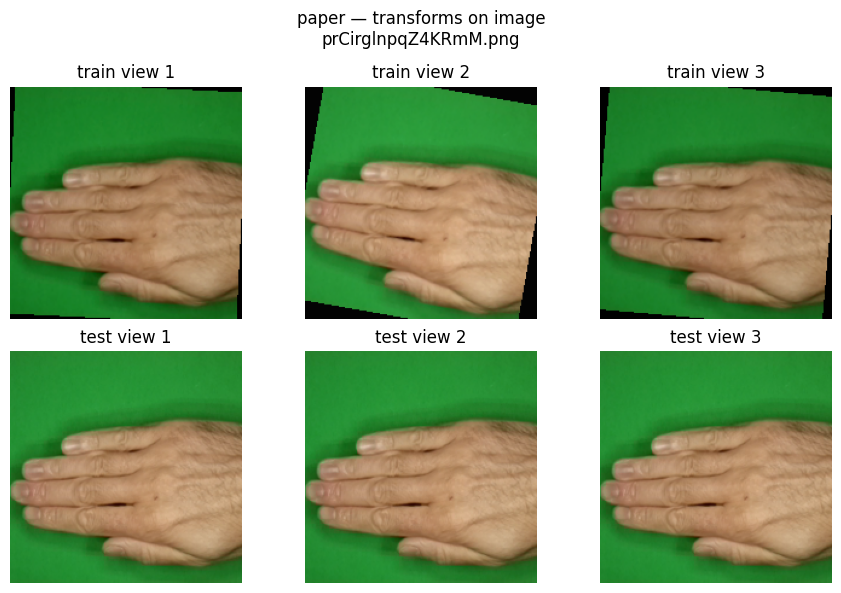

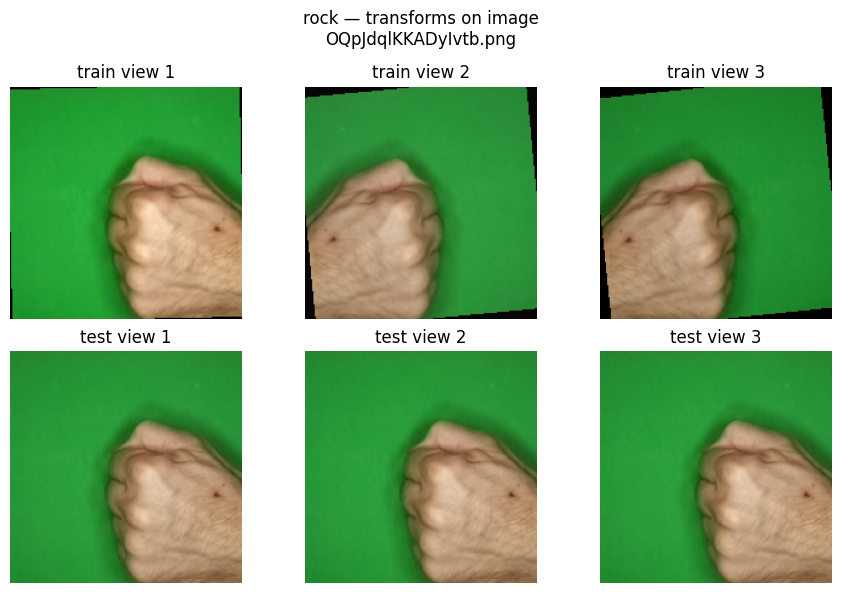

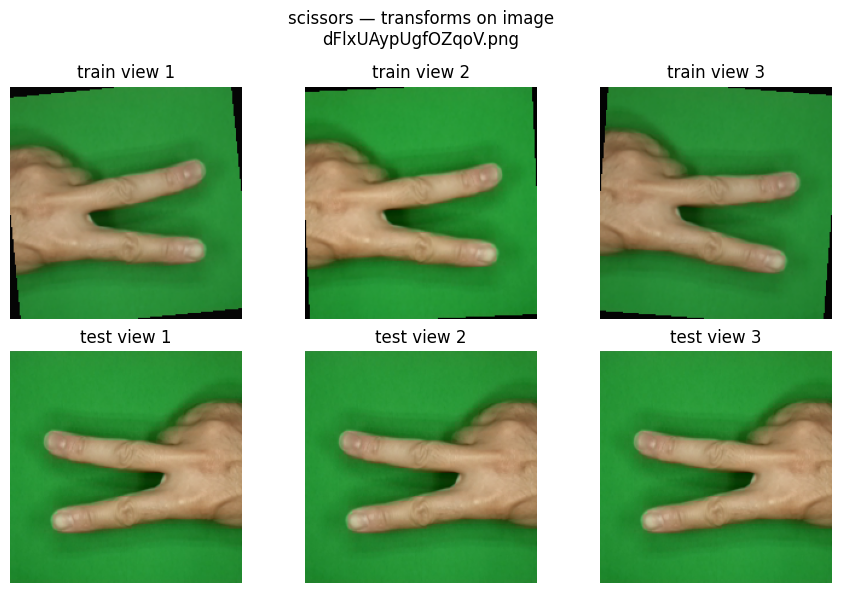

In [47]:
def _tensor_to_img(t: torch.Tensor):
    """Undo Normalize([0.5]*3,[0.5]*3) and convert CHW->HWC for imshow."""
    if not isinstance(t, torch.Tensor):
        return t
    t = t.detach().cpu()
    if t.ndim == 3 and t.shape[0] in (1, 3):
        t = (t * 0.5 + 0.5).clamp(0, 1)   # unnormalize
        t = t.permute(1, 2, 0).numpy()    # CHW -> HWC
    return t

def _pick_random_image(class_dir: Path) -> Path:
    cand = [p for p in class_dir.iterdir() if p.suffix.lower() in IMG_EXTS]
    if not cand:
        raise FileNotFoundError(f"No images found in {class_dir}")
    return random.choice(cand)

def visualize_transforms_for_class(
    data_dir: Path,
    cls: str,
    train_tf,
    test_tf,
    n: int = 3,
    seed: int = 42,
    save_path: Optional[Path] = None,
):
    """
    Show N train-augmented views and N test-transformed views of the SAME image.
    If provided, saves to save_path, then shows the figure.
    """
    random.seed(seed)
    img_path = _pick_random_image(data_dir / cls)
    img = Image.open(img_path).convert("RGB")

    fig, axes = plt.subplots(2, n, figsize=(3*n, 6))
    for i in range(n):
        tr = train_tf(img)
        te = test_tf(img)

        axes[0, i].imshow(_tensor_to_img(tr))
        axes[0, i].set_title(f"train view {i+1}")
        axes[0, i].axis("off")

        axes[1, i].imshow(_tensor_to_img(te))
        axes[1, i].set_title(f"test view {i+1}")
        axes[1, i].axis("off")

    axes[0, 0].set_ylabel("TRAIN tf", fontsize=10)
    axes[1, 0].set_ylabel("TEST tf",  fontsize=10)
    fig.suptitle(f"{cls} — transforms on image\n{img_path.name}", y=0.98)

    plt.tight_layout()
    if save_path:
        save_path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=150)
    plt.show()


cfg = Settings()
train_tf, test_tf = build_transforms(cfg.img_size)

FIGURES_DIR = Path.cwd() / "figures"   
classes = sorted([d.name for d in (PATHS.DATA_PROC / "train").iterdir() if d.is_dir()])

# Visualize one class at a time
for cls in classes:
    visualize_transforms_for_class(
        data_dir=PATHS.DATA_PROC / "train",  # use processed/train images as source
        cls=cls,
        train_tf=train_tf,
        test_tf=test_tf,
        n=3,                                  # views per pipeline
        seed=42,
        save_path=FIGURES_DIR / f"viz_tf_{cls}.png"
    )
